<a href="https://colab.research.google.com/github/ryanmdpeters21/Data-Analysis/blob/main/Football_Analytics_with_Python_chap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nfl_data_py
!pip install numpy
!pip install nfl_data_py
!pip install statsmodels
!pip install matplotlib
!pip install seaborn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=ea0088d6440118386a35307a1e66adaa5da12a6f77f28f3369314bf9f52eb2ad
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [3]:
# We want to create a multiple linear regression model.
# we will use the following variables as features:
# down (down), distance (ydstogo), yards to go to endzone (yardline_100),
# run location (run_location), and score differential (score_differential)
# We start by importing our packages.

import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# We can now load in our data.

seasons = range(2016, 2022+1)
pbp_py = nfl.import_pbp_data(seasons)

pbp_py_run = \
  pbp_py\
  .query('play_type == "run" & rusher_id.notnull() &' +
         "down.notnull() & run_location.notnull()")\
  .reset_index()

pbp_py_run\
  .loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


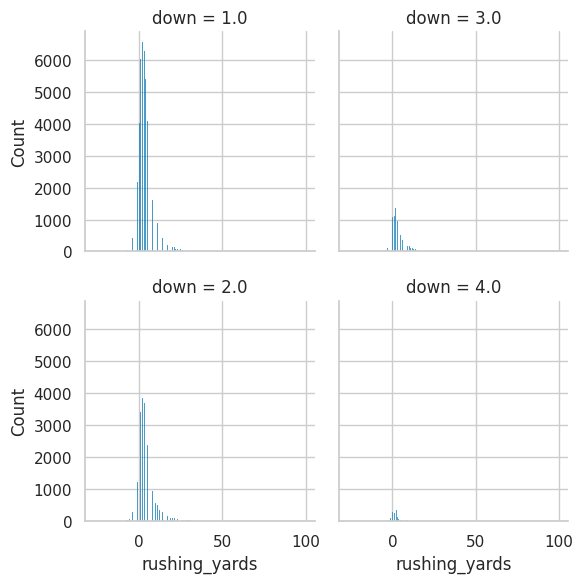

In [4]:
# Now we can create a histogram for down and rushing yards gained.
sns.set_theme(style='whitegrid', palette='colorblind')

# Change down to integer.
pbp_py_run.down =\
  pbp_py_run.down.astype(str)

# Plot rushing yards by down
g = sns.FacetGrid(data=pbp_py_run, col='down', col_wrap=2);
g.map_dataframe(sns.histplot, x='rushing_yards');
plt.show();

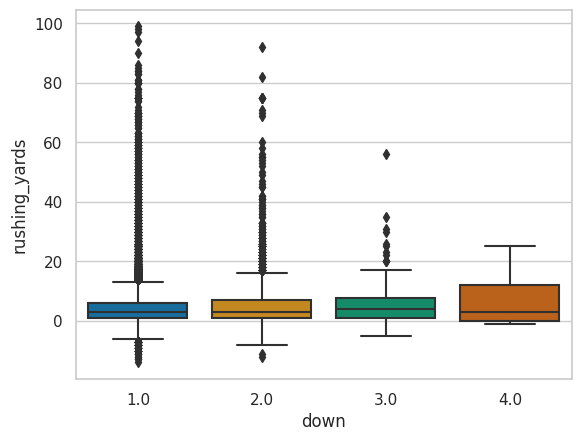

In [5]:
# We can see that down decreases rushing yards,
# but rushes often happen on late downs with small distances.
# Let's look at situations where ydstogo == 10.
sns.boxplot(data=pbp_py_run.query('ydstogo == 10'),
            x='down',
            y='rushing_yards');
plt.show()

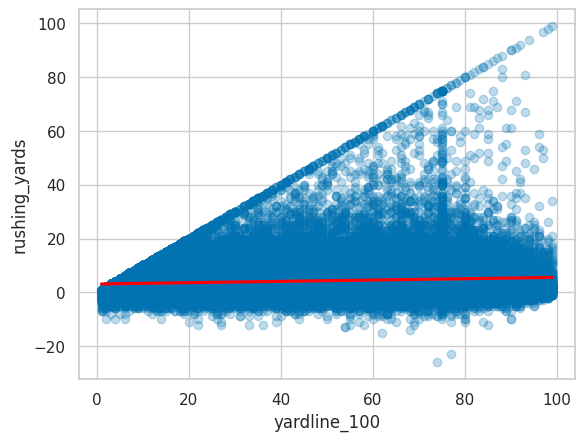

In [6]:
# We can see that down affects rushing yards on a play and should be accounted for.
# Let's look at yards to the endzone in seaborn
sns.regplot(
    data=pbp_py_run,
    x='yardline_100',
    y='rushing_yards',
    scatter_kws={'alpha': 0.25},
    line_kws={'color': 'red'}
);
plt.show();

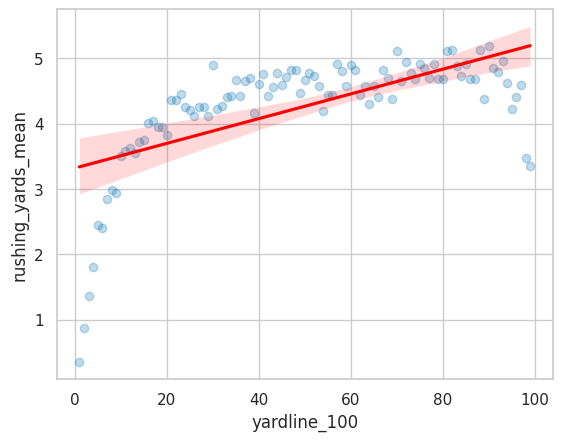

In [7]:
# This is tough to interpret and doesn't provide much information.
# Let's see what happens when we bin and average, similar to chapter 3.
pbp_py_run_y100 =\
  pbp_py_run\
  .groupby('yardline_100')\
  .agg({'rushing_yards': ['mean']})

pbp_py_run_y100.columns =\
  list(map('_'.join, pbp_py_run_y100.columns))

pbp_py_run_y100.reset_index(inplace=True)

# Now we can create our plot
sns.regplot(
    data=pbp_py_run_y100,
    x='yardline_100',
    y='rushing_yards_mean',
    scatter_kws={'alpha': 0.25},
    line_kws={'color': 'red'}
);
plt.show();

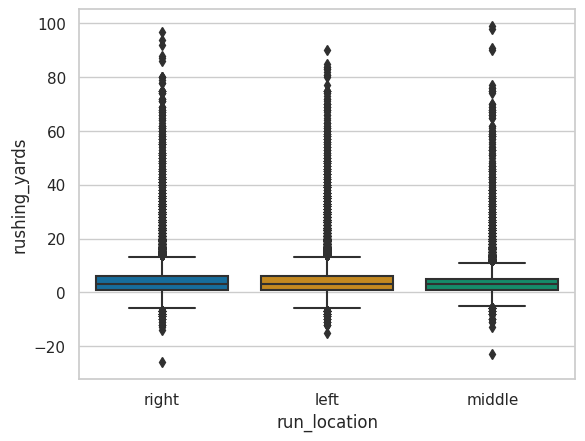

In [8]:
# We can see that there are non-linearities near both of the endzones.
# We know teams play tough red-zone defense combined with minimal field space.
# Teams will also play aggresively near the offensive endzone, trying to force a safety.
# We will not explore these non-linearities for now.
# Let's look at run location next.
sns.boxplot(data=pbp_py_run,
            x='run_location',
            y='rushing_yards');
plt.show();

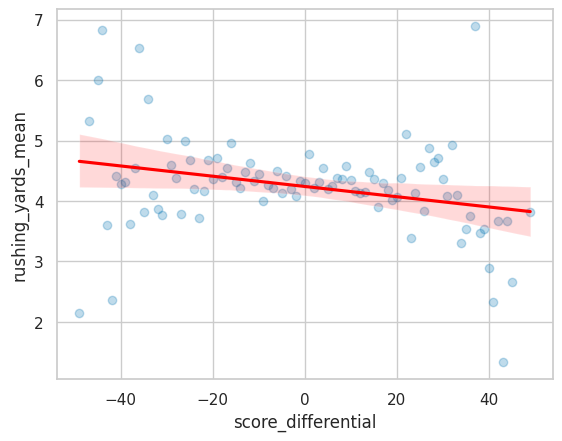

In [9]:
# We can see that the majority of plays (75th percentile) go less than 10 yards.
# Run location doesn't have much effect on the play success.
# Let's look at score differential, by binning and aggregating for yds to go to endzone.
pbp_py_run_sd =\
  pbp_py_run\
  .groupby('score_differential')\
  .agg({'rushing_yards': ['mean']}
)

pbp_py_run_sd.columns =\
  list(map('_'.join, pbp_py_run_sd.columns))

pbp_py_run_sd.reset_index(inplace=True)

# Now we can create our plot.
sns.regplot(
    data=pbp_py_run_sd,
    x='score_differential',
    y='rushing_yards_mean',
    scatter_kws={'alpha': 0.25},
    line_kws={'color': 'red'}
);
plt.show()

In [10]:
# We can now create our rushing yard model.
# We will start by fitting the model with statsmodels package.
# Then we can save our residuals as RYOE.
pbp_py_run.down =\
  pbp_py_run.down.astype(str)

expected_yards_py =\
  smf.ols(
      data=pbp_py_run,
      formula='rushing_yards ~ 1 + down + ydstogo + ' +
      'down:ydstogo + yardline_100 + ' +
      'run_location + score_differential')\
      .fit()

pbp_py_run['ryoe'] = \
  expected_yards_py.resid

# Now we can examine the summary of our model in Python.
print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          3.43e-313
Time:                        00:41:25   Log-Likelihood:            -2.9764e+05
No. Observations:               91442   AIC:                         5.953e+05
Df Residuals:                   91430   BIC:                         5.954e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [11]:
# We can now create a new metric: RYOE.
# We can analyze RYOE totals, means and YPC.
# We look at players w/ >50 carries.
ryoe_py =\
  pbp_py_run\
  .groupby(['season', 'rusher_id', 'rusher'])\
  .agg({
      'ryoe': ['count', 'sum', 'mean'],
      'rushing_yards': ['mean']})

ryoe_py.columns =\
  list(map('_'.join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

ryoe_py =\
  ryoe_py\
  .rename(columns={
      'ryoe_count': 'n',
      'ryoe_sum': 'ryoe_total',
      'ryoe_mean': 'ryoe_per',
      'rushing_yards_mean': 'yards_per_carry'
  })\
  .query('n > 50')

print(ryoe_py\
      .sort_values('ryoe_total', ascending=False)
      )

      season   rusher_id      rusher    n  ryoe_total  ryoe_per  \
1870    2021  00-0036223    J.Taylor  332  471.232840  1.419376   
1350    2020  00-0032764     D.Henry  395  345.948778  0.875820   
1183    2019  00-0034796   L.Jackson  126  328.524757  2.607339   
1069    2019  00-0032764     D.Henry  386  311.641243  0.807361   
1383    2020  00-0033293     A.Jones  221  301.778866  1.365515   
...      ...         ...         ...  ...         ...       ...   
627     2018  00-0027029     L.McCoy  161 -208.392834 -1.294365   
51      2016  00-0027155  R.Jennings  186 -228.084591 -1.226261   
629     2018  00-0027325    L.Blount  154 -235.865233 -1.531592   
991     2019  00-0030496      L.Bell  245 -338.432836 -1.381359   
246     2016  00-0032241    T.Gurley  278 -344.314622 -1.238542   

      yards_per_carry  
1870         5.454819  
1350         5.232912  
1183         6.880952  
1069         5.145078  
1383         5.565611  
...               ...  
627          3.192547  
51 

In [14]:
# We can sort by RYOE per carry.
print(
    ryoe_py\
    .sort_values('ryoe_per', ascending=False)
)

      season   rusher_id        rusher    n  ryoe_total  ryoe_per  \
2103    2022  00-0034796     L.Jackson   72  280.752317  3.899338   
1183    2019  00-0034796     L.Jackson  126  328.524757  2.607339   
1210    2019  00-0035228      K.Murray   53  137.636412  2.596913   
2239    2022  00-0036945      J.Fields   77  177.409631  2.304021   
1467    2020  00-0034796     L.Jackson  118  258.059489  2.186945   
...      ...         ...           ...  ...         ...       ...   
1901    2021  00-0036414       C.Akers   72 -129.834294 -1.803254   
533     2017  00-0032940  D.Washington   57 -105.377929 -1.848736   
1858    2021  00-0035860       T.Jones   54 -100.987077 -1.870131   
60      2016  00-0027791      J.Starks   63 -129.298259 -2.052353   
1184    2019  00-0034799     K.Ballage   74 -191.983153 -2.594367   

      yards_per_carry  
2103         7.930555  
1183         6.880952  
1210         6.867925  
2239         6.506494  
1467         6.415254  
...               ...  
190

In [15]:
# I deleted some code here. Whoops. :(
    # F